In [1]:
## 20180908 update
## 11/15/15: modify to use only 2009-12-31 data for roc curves and optimal cut-off graphs
## roc curves for 2009-2014 data
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## def(td,ff,px): # where td is dataframe, ff & px are column names of failflag and probdefault
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

In [3]:
## make ctlst (cutlist) of 73 points spaced for good charts:
ctlst2 = list(np.arange(0,2,.1)) + list(np.arange(2,5,.5)) + list(np.arange(5,15,1)) + list(np.arange(15,90,5))
ctlst2 = ctlst2 + list(np.arange(90,97,1)) + list(np.arange(97,99,.5)) + list(np.arange(99,100,.1)) + [100]
#ctlst = [np.round(x,1) for x in ctlst]
ctlst = [np.round(float(x)/100,3) for x in ctlst2]
ctlst[15:25]

[0.014999999999999999,
 0.016,
 0.017000000000000001,
 0.017999999999999999,
 0.019,
 0.02,
 0.025000000000000001,
 0.029999999999999999,
 0.035000000000000003,
 0.040000000000000001]

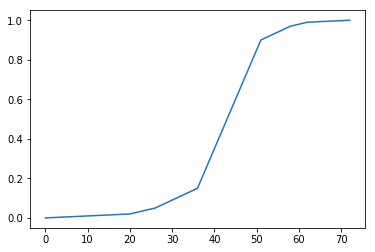

In [4]:
plt.plot(np.arange(len(ctlst)),ctlst)

In [5]:
## function for roc points (ctlst: 73 cuts) (1.1 sec to solve):
def roc(td,ff,px,ct):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list

  xm = pd.DataFrame(columns=['cut','fail', 'surv', 'sens', 'spec', 'FPR'],dtype='float')

  for i in np.arange(len(ct)):
    x1 = ct[i]
    x2 = sum((py[px] > x1)*1)
    x3 = sum((pn[px] > x1)*1)
    x4 = float(x2)/float(ly)
    x5 = float(ln - x3)/float(ln)
    x6 = 1 - x5
    xm=xm.append({'cut':x1,'fail':x2,'surv':x3,'sens':x4,'spec':x5,'FPR':x6},ignore_index=True)

  return xm

In [6]:
### read in all bank data with ratios to run ROC analyses:
dff = pd.read_csv("allbanks_f2468_roe0mm2_20091231.csv",index_col=0)
dff['AsOf'] = pd.to_datetime(dff['AsOf'])
dff['FailDate'] = pd.to_datetime(dff['FailDate'])
dff.head()

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
2      37 2002-06-30  BANK OF HANCOCK COUNTY    GA  69304.0  0.364757   
3      37 2002-09-30  BANK OF HANCOCK COUNTY    GA  71970.0  0.495989   
4      37 2002-12-31  BANK OF HANCOCK COUNTY    GA  74327.0  0.610962   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   
2  0.206747  4.599485  1.927457  1.294383    ...      0   0   0        1.0   
3  0.325492  4.492631  1.833764  1.235163    ...      0   0   0        1.0   
4  0.268236  4.436347  1.816232  1.214158    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  2.057203e-08  2.715938e-08  3.110231e-07  1.900500e-08  3.771580e-07   
1  2.345935e-08  3.112617e-08  3.486561e-07  2.219058e-08  4.278112e-07   
2  2.962714e-08  3.900601e-08  4.260954e-07  2.890704e-08  5.291975e-07   
3  5.007191e-08  6.522655e-08  6.718506e-07  5.265142e-08  8.623873e-07   
4  1.821867e-08  2.510827e-08  2.826958e-07  1.703912e-08  3.491254e-07   

       f6_5  
0  0.000002  
1  0.000002  
2  0.000003  
3  0.000004  
4  0.000002  

[5 rows x 33 columns]

In [7]:
dff['AsOf'].min(),dff['AsOf'].max()

(Timestamp('2001-12-31 00:00:00'), Timestamp('2018-06-30 00:00:00'))

In [8]:
prm0 = pd.read_csv("f246_params_roe0mm2_2009.csv",index_col=0)
#prm225 = pd.read_csv("f246_params_alt225mm_2009.csv",index_col=0)

In [9]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   
1  0.0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   
2  3.0  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519180   
3  2.0  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519780   
4  4.0  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   
5  4.0  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.613496 -2.811250 -0.468572 -0.025504  0.085620  0.034020  
1   lnTotAst  0.607906 -6.580815 -0.447084 -0.029117  0.085405  0.306157  
2  eBrok_Dep  0.544649 -2.212065 -0.400399  0.112586 -0.029288  0.040636  
3  eBrok_Dep  0.541573 -0.917821 -0.524381  0.118437 -0.309044  0.038061  
4       rROA  0.459248 -1.259899 -0.419314  0.147909  0.041358 -0.290305  
5       rROE  0.458956 -2.072620 -0.342553  0.140668  0.042746 -0.026573

In [10]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [11]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [12]:
targ = pd.to_datetime('2009-12-31')
thresh = 0 ## no minimum size threshold (not needed)
alt = '' ## or alt = ''
dfh = dff[(dff['AsOf']<=targ)&(dff['eTotAst']>(thresh*1000))]\
      [['IDRSSD','AsOf','Name','FailDate']+xcol+fcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh), len(dff) ## 259210, 478607

(259210, 478607)

In [13]:
dfh[xcol].max()

rcTotLn      3.543633e+03
qnTotLn      1.000000e+02
rNIM         4.160000e+04
rPPNR        5.272914e+02
rROA         3.423426e+02
rROE         5.877828e+02
rEff         5.480120e+07
eLn_Dep      9.934150e+02
aFF_TA       1.534201e+02
eBrok_Dep    1.000000e+02
eT1rb        1.999829e+02
eTotrb       2.268312e+02
eALLL_Ln     1.000000e+02
lnTotAst     2.129349e+01
dtype: float64

In [14]:
dfh[xcol].min()

rcTotLn     -5.000000e-01
qnTotLn      0.000000e+00
rNIM        -1.360000e+04
rPPNR       -6.429146e+01
rROA        -7.697304e+01
rROE        -1.998472e+02
rEff        -3.359000e+08
eLn_Dep      0.000000e+00
aFF_TA      -2.722560e+02
eBrok_Dep    0.000000e+00
eT1rb        0.000000e+00
eTotrb       0.000000e+00
eALLL_Ln     0.000000e+00
lnTotAst     6.486161e+00
dtype: float64

In [15]:
## screening criteria:
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['lnTotAst']>2]
dfh= dfh[dfh['eT1rb']<=200]
len(dfh) # 259210

259210

In [16]:
## set fflags to zero if FailDate after targ2 date (12/31/2010); that is, for f4
## increment date by interval:
targ2 = pd.to_datetime((targ.year+1)*10000 + targ.month*100 + targ.day, format='%Y%m%d')  # handles leap years
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]
targ2

Timestamp('2010-12-31 00:00:00')

In [17]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2011-03-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head(8)

IDRSSD       AsOf                   Name   FailDate  f2  f4  f6  f8
5637    16337 2009-09-30           WAKULLA BANK 2010-10-01   0   0   1   1
5638    16337 2009-12-31           WAKULLA BANK 2010-10-01   0   1   1   1
15081   41647 2009-09-30   FIRST BANKING CENTER 2010-11-19   0   0   1   1
15082   41647 2009-12-31   FIRST BANKING CENTER 2010-11-19   0   1   1   1
20126   54357 2009-09-30  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
20127   54357 2009-12-31  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
43947  117841 2009-09-30   EVERGREEN STATE BANK 2011-01-28   0   0   0   0
43948  117841 2009-12-31   EVERGREEN STATE BANK 2011-01-28   0   0   0   0

In [18]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
5637   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
5638   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
7251   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
7252   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
8406   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [19]:
dff.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8', u'Intercept',
       u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4', u'f6_5'],
      dtype='object')

In [20]:
dfh.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'FailDate', u'rcTotLn', u'qnTotLn',
       u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep', u'aFF_TA',
       u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst', u'f2',
       u'f4', u'f6', u'f8', u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4',
       u'f6_5'],
      dtype='object')

In [21]:
### generate forecasts for all 4-var models:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in prm0.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cm = pd.DataFrame(res.params).T
  cm.columns = ['Int','c1','c2','c3','c4']
  cm['idx'] = idx
  cm['v4'] = row['v4']
  cv4 = cv4.append(cm.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)+'rr'] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)+'rr'] = p_tot

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])


Optimization terminated successfully.
         Current function value: 0.004107
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004167
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010750
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010822
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019318
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019328
         Iterations 12


In [22]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   
1  1.0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   
2  2.0  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519180   
3  3.0  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519780   
4  4.0  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   
5  5.0  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.613496 -2.811250 -0.468572 -0.025504  0.085620  0.034020  
1   lnTotAst  0.607906 -6.580815 -0.447084 -0.029117  0.085405  0.306157  
2  eBrok_Dep  0.544649 -2.212065 -0.400399  0.112586 -0.029288  0.040636  
3  eBrok_Dep  0.541573 -0.917821 -0.524381  0.118437 -0.309044  0.038061  
4       rROA  0.459248 -1.259899 -0.419314  0.147909  0.041358 -0.290305  
5       rROE  0.458956 -2.072620 -0.342553  0.140668  0.042746 -0.026573

In [23]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   
1  0.0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   
2  3.0  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519180   
3  2.0  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519780   
4  4.0  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   
5  4.0  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.613496 -2.811250 -0.468572 -0.025504  0.085620  0.034020  
1   lnTotAst  0.607906 -6.580815 -0.447084 -0.029117  0.085405  0.306157  
2  eBrok_Dep  0.544649 -2.212065 -0.400399  0.112586 -0.029288  0.040636  
3  eBrok_Dep  0.541573 -0.917821 -0.524381  0.118437 -0.309044  0.038061  
4       rROA  0.459248 -1.259899 -0.419314  0.147909  0.041358 -0.290305  
5       rROE  0.458956 -2.072620 -0.342553  0.140668  0.042746 -0.026573

In [24]:
dv4.to_csv("modelrerun_f246_params_roe0mm2_2009.csv")

In [25]:
fcolrr = [x for x in list(dff.columns) if x[0:1]=='f']
fcolrr

['f2',
 'f4',
 'f6',
 'f8',
 'f2_0',
 'f2_1',
 'f4_2',
 'f4_3',
 'f6_4',
 'f6_5',
 'f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr']

In [26]:
dffsum=dff[['AsOf']+fcolrr].groupby('AsOf').sum()
dffsum.ix['2009':'2010']

f2   f4   f6   f8       f2_0       f2_1        f4_2        f4_3  \
AsOf                                                                          
2009-03-31  55  129  204  255  41.047278  39.643902   94.181394   95.097186   
2009-06-30  59  137  196  239  50.568246  51.484422  112.627910  110.009971   
2009-09-30  54  124  175  219  50.507301  51.804447  116.984927  112.923355   
2009-12-31  66  125  168  211  75.399878  76.943280  154.940632  150.804907   
2010-03-31  55  106  149  181  72.780122  76.728780  144.471561  130.629660   
2010-06-30  43   86  129  153  60.101735  65.763056  121.237870  104.609114   
2010-09-30  36   79  110  130  54.318831  59.985724  109.622088   91.191040   
2010-12-31  34   77  101  119  53.605358  58.166848  108.968266   97.607671   

                  f6_4        f6_5     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                   
2009-03-31  140.728483  138.630939  41.047278  39.643902   94.181394   
2009-06-30  159.576325  161.180195  50.568246  51.484422  112.627910   
2009-09-30  166.532986  170.076020  50.507301  51.804447  116.984927   
2009-12-31  202.804480  207.574399  75.399878  76.943280  154.940632   
2010-03-31  177.605061  191.396783  72.780122  76.728780  144.471561   
2010-06-30  147.364934  164.213277  60.101735  65.763056  121.237870   
2010-09-30  129.799141  149.598464  54.318831  59.985724  109.622088   
2010-12-31  134.162595  147.648308  53.605358  58.166848  108.968266   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   95.097186  140.728483  138.630939  
2009-06-30  110.009971  159.576325  161.180195  
2009-09-30  112.923355  166.532986  170.076020  
2009-12-31  150.804907  202.804480  207.574399  
2010-03-31  130.629660  177.605061  191.396783  
2010-06-30  104.609114  147.364934  164.213277  
2010-09-30   91.191040  129.799141  149.598464  
2010-12-31   97.607671  134.162595  147.648308

In [27]:
## single variable models for all fx:
dvv = pd.DataFrame(columns=['fx','v1', 'r1'])
cvv = pd.DataFrame(columns=['fx','v1','Int','c1'])

vr=prm0[['v1','v2','v3','v4']].values
vrlst = list(set(e for r in vr for e in r))  ## list of unique variables among coefficients
vrlst = vrlst + ['eLn_Dep','aFF_TA']

for x in vrlst:
  for y in ['f2','f4','f6']:
    eqnc = y + " ~ " + x  # regression eqn
    pvar = ["Intercept", x]  # var for predictions
    yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
    res = sm.Logit(yc, Xc).fit()
    dvv = dvv.append({'fx':y,'v1':x,'r1':res.prsquared},ignore_index=True)
    cm = pd.DataFrame(res.params).T
    cm.columns = ['Int','c1']
    cm['fx'] = y
    cm['v1'] = x
    cvv = cvv.append(cm)
    pred_tot = res.predict(Xc)
    dfh[y+'_'+x] = pred_tot
    p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
    dff[y+'_'+x] = p_tot

cvv = cvv.reset_index(drop=True)
dvv = dvv.reset_index(drop=True)
dvv = dvv.merge(cvv, how='inner', on=['fx','v1'])

Optimization terminated successfully.
         Current function value: 0.010332
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022914
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034614
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005402
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014169
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024878
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009156
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020161
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031299
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.00

In [28]:
dvv

fx         v1            r1        Int        c1
0   f2   lnTotAst  2.776448e-02 -11.112936  0.371887
1   f4   lnTotAst  2.937546e-02 -10.070537  0.363334
2   f6   lnTotAst  3.106602e-02  -9.560640  0.362184
3   f2       rROE  4.916177e-01  -7.335602 -0.056758
4   f4       rROE  3.998078e-01  -6.056255 -0.060479
5   f6       rROE  3.036069e-01  -5.318802 -0.058228
6   f2       rROA  1.383739e-01  -6.617588 -0.273996
7   f4       rROA  1.460057e-01  -5.669035 -0.329296
8   f6       rROA  1.238686e-01  -5.127828 -0.334232
9   f2      eT1rb  5.221243e-01   2.875025 -0.973274
10  f4      eT1rb  3.976050e-01   3.686162 -0.908604
11  f6      eT1rb  2.906983e-01   2.973008 -0.756279
12  f2    qnTotLn  1.341141e-01  -6.971926  0.169443
13  f4    qnTotLn  2.133018e-01  -6.355191  0.275215
14  f6    qnTotLn  2.089553e-01  -5.882838  0.300752
15  f2  eBrok_Dep  5.514164e-02  -6.895088  0.041498
16  f4  eBrok_Dep  6.549667e-02  -5.973650  0.042619
17  f6  eBrok_Dep  7.281008e-02  -5.488328  0.043709
18  f2    eLn_Dep  1.975284e-03  -6.860932  0.003604
19  f4    eLn_Dep  4.018038e-03  -5.987523  0.004277
20  f6    eLn_Dep  6.638744e-03  -5.546010  0.004869
21  f2     aFF_TA  2.756565e-03  -6.672363  0.019747
22  f4     aFF_TA  8.814205e-04  -5.691086  0.011326
23  f6     aFF_TA  2.374905e-07  -5.142546  0.000193

In [29]:
dvv.to_csv("SingleVar_params_roe0mm2_2009.csv")

In [30]:
dff.to_csv("allbanks_f2468_roe0mm2_20091231_singles.csv")
dfh.to_csv("modelbanks_f2468_roe0mm2_2009_singles.csv")

In [31]:
len(dff), len(dfh) # 478607, 259210

(478607, 259210)

In [32]:
fcol = [x for x in list(dff.columns) if x[0]=='f']
fcol[10:26]

['f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr',
 'f2_lnTotAst',
 'f4_lnTotAst',
 'f6_lnTotAst',
 'f2_rROE',
 'f4_rROE',
 'f6_rROE',
 'f2_rROA',
 'f4_rROA',
 'f6_rROA',
 'f2_eT1rb']

In [33]:
fnbr = dff[['AsOf']+fcol[0:5]+fcol[10:16]].groupby('AsOf').sum()
fnbr['2009':'2011']

f2   f4   f6   f8       f2_0     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                         
2009-03-31  55  129  204  255  41.047278  41.047278  39.643902   94.181394   
2009-06-30  59  137  196  239  50.568246  50.568246  51.484422  112.627910   
2009-09-30  54  124  175  219  50.507301  50.507301  51.804447  116.984927   
2009-12-31  66  125  168  211  75.399878  75.399878  76.943280  154.940632   
2010-03-31  55  106  149  181  72.780122  72.780122  76.728780  144.471561   
2010-06-30  43   86  129  153  60.101735  60.101735  65.763056  121.237870   
2010-09-30  36   79  110  130  54.318831  54.318831  59.985724  109.622088   
2010-12-31  34   77  101  119  53.605358  53.605358  58.166848  108.968266   
2011-03-31  33   64   86   97  47.815292  47.815292  52.768841   96.559106   
2011-06-30  27   50   67   78  38.722864  38.722864  43.479592   81.918137   
2011-09-30  19   39   50   62  36.354966  36.354966  41.159445   74.935508   
2011-12-31  18   36   48   56  32.046172  32.046172  35.953498   66.239802   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   95.097186  140.728483  138.630939  
2009-06-30  110.009971  159.576325  161.180195  
2009-09-30  112.923355  166.532986  170.076020  
2009-12-31  150.804907  202.804480  207.574399  
2010-03-31  130.629660  177.605061  191.396783  
2010-06-30  104.609114  147.364934  164.213277  
2010-09-30   91.191040  129.799141  149.598464  
2010-12-31   97.607671  134.162595  147.648308  
2011-03-31   82.089473  114.678295  130.618110  
2011-06-30   66.664958   96.057000  113.365582  
2011-09-30   60.304245   86.037491  102.689593  
2011-12-31   58.024685   81.353184   91.963024

In [34]:
###########################################################################################
# change this to 20091231 only!!!
###########################################################################################

dffg = dff[dff['AsOf']=='2009-12-31'][['AsOf']+fcol]

In [35]:
len(dffg)  ## 7220

7220

In [36]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
488415 2009-12-31   0   0   0   0  8.829546e-10  1.267444e-09  2.786002e-08   
488453 2009-12-31   0   0   0   0  6.896306e-07  8.833574e-07  7.040838e-06   

                f4_3          f6_4    ...      f6_qnTotLn  f2_eBrok_Dep  \
488415  2.136526e-08  7.937966e-07    ...        0.002779      0.001012   
488453  2.234755e-06  2.030625e-05    ...        0.002779      0.001012   

        f4_eBrok_Dep  f6_eBrok_Dep  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
488415      0.002538      0.004118    0.001299    0.003233    0.005200   
488453      0.002538      0.004118    0.001335    0.003340    0.005395   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
488415   0.001673   0.003951   0.005825  
488453   0.001565   0.003802   0.005821  

[2 rows x 41 columns]

In [37]:
dffg[['f4','f6']].groupby('f4').count() # 7095, 125

f6
f4      
0   7095
1    125

In [38]:
dff[['f4','f6']].groupby('f4').count() # 476876, 1731

f6
f4        
0   476876
1     1731

In [39]:
%time xc = roc(dffg, 'f4', 'f4_2', ctlst) # 169ms

Wall time: 160 ms


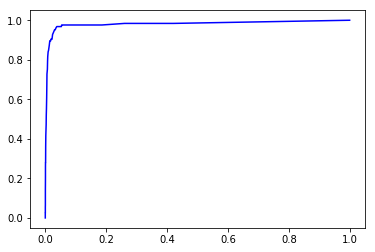

In [40]:
plt.plot(xc['FPR'],xc['sens'],c='b')

In [41]:
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py = td[td[ff]==1][[px,ff]]
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

%time x = auc(dffg, 'f4', 'f4_2rr') # 122ms

Wall time: 107 ms


In [42]:
x # 0.97993

0.9799306553911205

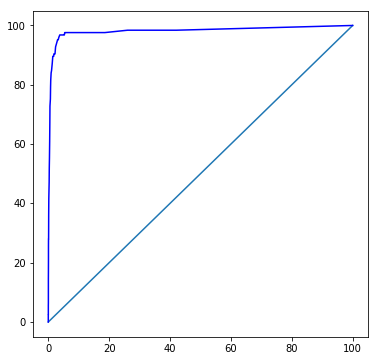

In [43]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,100],[0,100])
plt.plot(xc['FPR']*100,xc['sens']*100,c='b')
plt.show()

In [44]:
f4lst0=[x for x in list(dffg.columns) if x[0:2]=='f4']  ## all f4 columns
f4lst= [x for x in f4lst0 if x not in ['f4','f4_2','f4_3','f4_aFF_TA']]  ## no f4; only vars used in models plus 2 dummy vars
f4lst

['f4_2rr',
 'f4_3rr',
 'f4_lnTotAst',
 'f4_rROE',
 'f4_rROA',
 'f4_eT1rb',
 'f4_qnTotLn',
 'f4_eBrok_Dep',
 'f4_eLn_Dep']

In [45]:
f4auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f4lst:
  y = auc(dffg, 'f4', x)
  f4auc=f4auc.append({'modvar':x,'auc':y, 'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f4_2rr
f4_3rr
f4_lnTotAst
f4_rROE
f4_rROA
f4_eT1rb
f4_qnTotLn
f4_eBrok_Dep
f4_eLn_Dep


In [46]:
f4auc['aucs'] = f4auc.apply(lambda x: str(np.round(x['auc']*100,1)),axis=1)
f4auc

modvar       auc  aucs
0        f4_2rr  0.979931  98.0
1        f4_3rr  0.979301  97.9
2   f4_lnTotAst  0.633367  63.3
3       f4_rROE  0.974162  97.4
4       f4_rROA  0.954704  95.5
5      f4_eT1rb  0.973584  97.4
6    f4_qnTotLn  0.955529  95.6
7  f4_eBrok_Dep  0.734363  73.4
8    f4_eLn_Dep  0.551424  55.1

In [47]:
f4auc.to_csv("f4auc_roe0mm2_20091231exact.csv")

In [48]:
f6lst0=[x for x in list(dffg.columns) if x[0:2]=='f6']  ## all f4 columns
f6lst= [x for x in f6lst0 if x not in ['f6','f6_4','f6_5','f6_aFF_TA']] 
f6lst

['f6_4rr',
 'f6_5rr',
 'f6_lnTotAst',
 'f6_rROE',
 'f6_rROA',
 'f6_eT1rb',
 'f6_qnTotLn',
 'f6_eBrok_Dep',
 'f6_eLn_Dep']

In [49]:
f6auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f6lst:
  y = auc(dffg, 'f6', x)
  f6auc=f6auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f6_4rr
f6_5rr
f6_lnTotAst
f6_rROE
f6_rROA
f6_eT1rb
f6_qnTotLn
f6_eBrok_Dep
f6_eLn_Dep


In [50]:
f2lst0=[x for x in list(dffg.columns) if x[0:2]=='f2']  ## all f4 columns
f2lst= [x for x in f2lst0 if x not in ['f2','f2_0','f2_1','f2_aFF_TA']] 
f2lst

['f2_0rr',
 'f2_1rr',
 'f2_lnTotAst',
 'f2_rROE',
 'f2_rROA',
 'f2_eT1rb',
 'f2_qnTotLn',
 'f2_eBrok_Dep',
 'f2_eLn_Dep']

In [51]:
f2auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f2lst:
  y = auc(dffg, 'f2', x)
  f2auc=f2auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f2_0rr
f2_1rr
f2_lnTotAst
f2_rROE
f2_rROA
f2_eT1rb
f2_qnTotLn
f2_eBrok_Dep
f2_eLn_Dep


In [52]:
f2auc

modvar       auc  aucs
0        f2_0rr  0.972887  97.3
1        f2_1rr  0.972870  97.3
2   f2_lnTotAst  0.641819  64.2
3       f2_rROE  0.969896  97.0
4       f2_rROA  0.950608  95.1
5      f2_eT1rb  0.973566  97.4
6    f2_qnTotLn  0.947040  94.7
7  f2_eBrok_Dep  0.687505  68.8
8    f2_eLn_Dep  0.558073  55.8

In [53]:
f2auc.to_csv("f2auc_roe0mm2_20091231exact.csv")

In [54]:
f6auc.to_csv("f6auc_roe0mm2_20091231exact.csv")

In [55]:
f6auc

modvar       auc  aucs
0        f6_4rr  0.974817  97.5
1        f6_5rr  0.975011  97.5
2   f6_lnTotAst  0.631510  63.2
3       f6_rROE  0.960453  96.0
4       f6_rROA  0.942580  94.3
5      f6_eT1rb  0.965776  96.6
6    f6_qnTotLn  0.947506  94.8
7  f6_eBrok_Dep  0.725982  72.6
8    f6_eLn_Dep  0.562765  56.3

In [56]:
%time y = roc(dffg, 'f4', 'f4_2rr',ctlst) # 151ms

Wall time: 160 ms


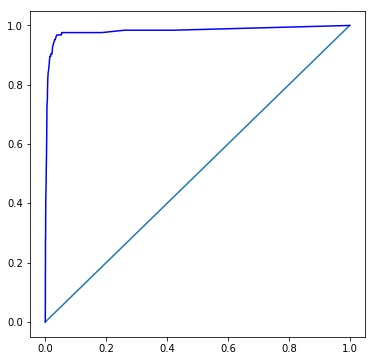

In [57]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(y['FPR'],y['sens'],c='b')
plt.show()

In [58]:
#f4roc:
for i in np.arange(len(f4lst)):
#for i in np.arange(2):
  v = f4lst[i]
  y = roc(dffg, 'f4', v, ctlst)
  if i == 0:
    f4roc = y[['cut','sens','FPR']]
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f4roc = f4roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f4roc.to_csv("f4rocpts_roe0mm2_20091231exact.csv")
f4roc.head()    

cut  f4_2rr_sens  f4_2rr_FPR  f4_3rr_sens  f4_3rr_FPR  f4_lnTotAst_sens  \
0  0.000        1.000    1.000000        1.000    1.000000             1.000   
1  0.001        0.984    0.420578        0.984    0.385201             1.000   
2  0.002        0.984    0.260465        0.976    0.250740             0.952   
3  0.003        0.976    0.185906        0.976    0.184778             0.736   
4  0.004        0.976    0.146300        0.976    0.146159             0.464   

   f4_lnTotAst_FPR  f4_rROE_sens  f4_rROE_FPR  f4_rROA_sens  f4_rROA_FPR  \
0         1.000000         1.000     1.000000         1.000     1.000000   
1         0.998027         0.992     0.899366         1.000     0.994221   
2         0.884144         0.984     0.390698         0.992     0.929105   
3         0.555180         0.976     0.220296         0.984     0.451304   
4         0.291191         0.976     0.168710         0.976     0.218464   

   f4_eT1rb_sens  f4_eT1rb_FPR  f4_qnTotLn_sens  f4_qnTotLn_FPR  \
0          1.000      1.000000            1.000        1.000000   
1          0.968      0.348414            1.000        1.000000   
2          0.968      0.247639            0.984        0.701480   
3          0.968      0.189147            0.984        0.388865   
4          0.968      0.147710            0.984        0.263002   

   f4_eBrok_Dep_sens  f4_eBrok_Dep_FPR  f4_eLn_Dep_sens  f4_eLn_Dep_FPR  
0              1.000          1.000000            1.000        1.000000  
1              1.000          1.000000            1.000        1.000000  
2              1.000          1.000000            1.000        1.000000  
3              0.704          0.277378            1.000        0.942213  
4              0.464          0.142918            0.016        0.039042

In [59]:
######### CAUTION ############################################
# shortcut to skip earlier processing and get to charts below
##############################################################

## read auc files:
#f2auc= pd.read_csv("f2auc_roe0mm2_20091231.csv",index_col=0)
#f4auc= pd.read_csv("f4auc_roe0mm2_20091231.csv",index_col=0)
#f6auc= pd.read_csv("f6auc_roe0mm2_20091231.csv",index_col=0)
#f2auc['aucs'] = f2auc['aucs'].astype(str)
#f4auc['aucs'] = f4auc['aucs'].astype(str)
#f6auc['aucs'] = f6auc['aucs'].astype(str)

## read roc files:
#f2roc= pd.read_csv("f2rocpts_roe0mm2_2009.csv",index_col=0)
#f4roc= pd.read_csv("f4rocpts_roe0mm2_2009.csv",index_col=0)
#f6roc= pd.read_csv("f6rocpts_roe0mm2_2009.csv",index_col=0)

In [60]:
f2auc.dtypes

modvar     object
auc       float64
aucs       object
dtype: object

In [61]:
f4roc.columns

Index([u'cut', u'f4_2rr_sens', u'f4_2rr_FPR', u'f4_3rr_sens', u'f4_3rr_FPR',
       u'f4_lnTotAst_sens', u'f4_lnTotAst_FPR', u'f4_rROE_sens',
       u'f4_rROE_FPR', u'f4_rROA_sens', u'f4_rROA_FPR', u'f4_eT1rb_sens',
       u'f4_eT1rb_FPR', u'f4_qnTotLn_sens', u'f4_qnTotLn_FPR',
       u'f4_eBrok_Dep_sens', u'f4_eBrok_Dep_FPR', u'f4_eLn_Dep_sens',
       u'f4_eLn_Dep_FPR'],
      dtype='object')

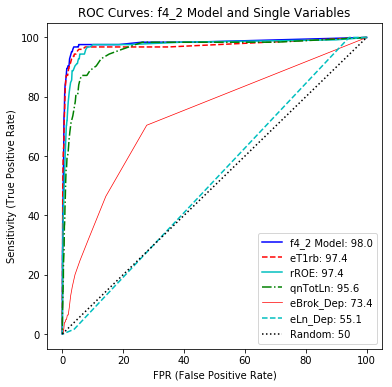

In [62]:
## Code to resize chart frame !!!!!!
#f4auc['aucs'] = f4auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f4roc['f4_2rr_FPR']*100,f4roc['f4_2rr_sens']*100,c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR']*100,f4roc['f4_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR']*100,f4roc['f4_rROE_sens']*100,c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR']*100,f4roc['f4_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR']*100,f4roc['f4_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
plt.plot(f4roc['f4_eLn_Dep_FPR']*100,f4roc['f4_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f4_2 Model and Single Variables')
plt.savefig('ROC_f4_roe0mm2_20091231exact.png', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
#f6roc:
for i in np.arange(len(f6lst)):
#for i in np.arange(2):
  v = f6lst[i]
  y = roc(dffg, 'f6', v, ctlst)
  if i == 0:
    f6roc = y[['cut','sens','FPR']]
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f6roc = f6roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f6roc.to_csv("f6rocpts_roe0mm2_20091231exact.csv")
f6roc.head()    

cut  f6_4rr_sens  f6_4rr_FPR  f6_5rr_sens  f6_5rr_FPR  f6_lnTotAst_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000          1.000000   
1  0.001     0.988095    0.575723     0.988095    0.621951          1.000000   
2  0.002     0.982143    0.443988     0.988095    0.472065          1.000000   
3  0.003     0.982143    0.349546     0.982143    0.363159          0.982143   
4  0.004     0.976190    0.290839     0.976190    0.291690          0.904762   

   f6_lnTotAst_FPR  f6_rROE_sens  f6_rROE_FPR  f6_rROA_sens  f6_rROA_FPR  \
0         1.000000      1.000000     1.000000      1.000000     1.000000   
1         1.000000      1.000000     0.992059      1.000000     0.996029   
2         0.993193      0.994048     0.918746      1.000000     0.992910   
3         0.925553      0.982143     0.696256      0.994048     0.968378   
4         0.749575      0.976190     0.428389      0.988095     0.810267   

   f6_eT1rb_sens  f6_eT1rb_FPR  f6_qnTotLn_sens  f6_qnTotLn_FPR  \
0       1.000000      1.000000         1.000000        1.000000   
1       0.964286      0.493902         1.000000        1.000000   
2       0.958333      0.400596         1.000000        1.000000   
3       0.958333      0.339053         0.988095        0.783040   
4       0.958333      0.286160         0.976190        0.535309   

   f6_eBrok_Dep_sens  f6_eBrok_Dep_FPR  f6_eLn_Dep_sens  f6_eLn_Dep_FPR  
0                1.0               1.0              1.0        1.000000  
1                1.0               1.0              1.0        1.000000  
2                1.0               1.0              1.0        1.000000  
3                1.0               1.0              1.0        1.000000  
4                1.0               1.0              1.0        0.990783

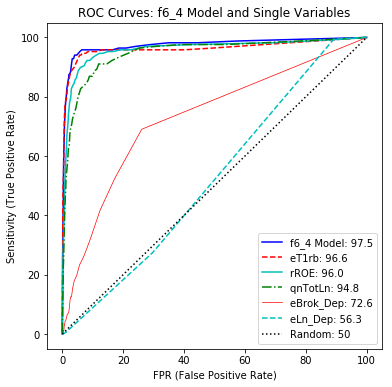

In [64]:
## Code to resize chart frame !!!!!!
#f6auc['aucs'] = f6auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f6roc['f6_4rr_FPR']*100,f6roc['f6_4rr_sens']*100,c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR']*100,f6roc['f6_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR']*100,f6roc['f6_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR']*100,f6roc['f6_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR']*100,f6roc['f6_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
plt.plot(f6roc['f6_eLn_Dep_FPR']*100,f6roc['f6_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f6_4 Model and Single Variables')
plt.savefig('ROC_f6_roe0mm2_20091231exact.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
#f2roc:
for i in np.arange(len(f2lst)):
#for i in np.arange(2):
  v = f2lst[i]
  y = roc(dffg, 'f2', v, ctlst)
  if i == 0:
    f2roc = y[['cut','sens','FPR']]
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f2roc = f2roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f2roc.to_csv("f2rocpts_roe0mm2_20091231exact.csv")
f2roc.head()    

cut  f2_0rr_sens  f2_0rr_FPR  f2_1rr_sens  f2_1rr_FPR  f2_lnTotAst_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000          1.000000   
1  0.001     0.969697    0.141040     0.969697    0.151943          0.833333   
2  0.002     0.969697    0.087364     0.969697    0.091977          0.303030   
3  0.003     0.969697    0.070171     0.969697    0.074783          0.106061   
4  0.004     0.969697    0.059128     0.969697    0.063181          0.075758   

   f2_lnTotAst_FPR  f2_rROE_sens  f2_rROE_FPR  f2_rROA_sens  f2_rROA_FPR  \
0         1.000000      1.000000     1.000000      1.000000     1.000000   
1         0.708135      0.969697     0.188566      0.984848     0.771177   
2         0.155717      0.954545     0.100923      0.954545     0.135588   
3         0.049063      0.954545     0.075482      0.863636     0.065977   
4         0.025720      0.954545     0.062622      0.757576     0.040816   

   f2_eT1rb_sens  f2_eT1rb_FPR  f2_qnTotLn_sens  f2_qnTotLn_FPR  \
0       1.000000      1.000000         1.000000        1.000000   
1       0.969697      0.145793         0.969697        0.745038   
2       0.969697      0.081213         0.954545        0.162147   
3       0.969697      0.055633         0.878788        0.082751   
4       0.969697      0.047246         0.818182        0.053257   

   f2_eBrok_Dep_sens  f2_eBrok_Dep_FPR  f2_eLn_Dep_sens  f2_eLn_Dep_FPR  
0           1.000000          1.000000              1.0        1.000000  
1           1.000000          1.000000              1.0        1.000000  
2           0.257576          0.085407              0.0        0.001398  
3           0.166667          0.037042              0.0        0.000419  
4           0.106061          0.022086              0.0        0.000140

In [66]:
f2roc.columns

Index([u'cut', u'f2_0rr_sens', u'f2_0rr_FPR', u'f2_1rr_sens', u'f2_1rr_FPR',
       u'f2_lnTotAst_sens', u'f2_lnTotAst_FPR', u'f2_rROE_sens',
       u'f2_rROE_FPR', u'f2_rROA_sens', u'f2_rROA_FPR', u'f2_eT1rb_sens',
       u'f2_eT1rb_FPR', u'f2_qnTotLn_sens', u'f2_qnTotLn_FPR',
       u'f2_eBrok_Dep_sens', u'f2_eBrok_Dep_FPR', u'f2_eLn_Dep_sens',
       u'f2_eLn_Dep_FPR'],
      dtype='object')

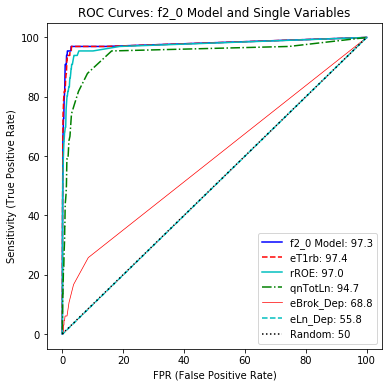

In [67]:
## Code to resize chart frame !!!!!!
#f2auc['aucs'] = f2auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f2roc['f2_0rr_FPR']*100,f2roc['f2_0rr_sens']*100,c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR']*100,f2roc['f2_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR']*100,f2roc['f2_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR']*100,f2roc['f2_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR']*100,f2roc['f2_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
plt.plot(f2roc['f2_eLn_Dep_FPR']*100,f2roc['f2_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f2_0 Model and Single Variables')
plt.savefig('ROC_f2_roe0mm2_20091231exact.png', dpi=300, bbox_inches='tight')
plt.show()

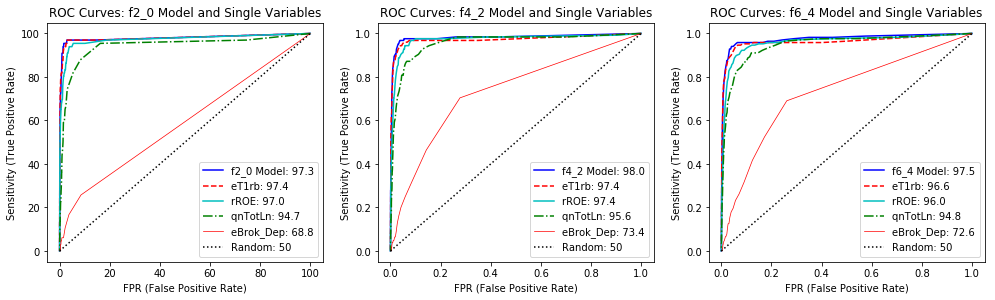

In [68]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.8, plSize[1]*1.1) )  ## double width, single height

plt.subplot(1, 3, 1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plt.plot(f2roc['f2_0rr_FPR']*100,f2roc['f2_0rr_sens']*100,c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR']*100,f2roc['f2_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR']*100,f2roc['f2_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR']*100,f2roc['f2_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR']*100,f2roc['f2_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
#plt.plot(f2roc['f2_eLn_Dep_FPR'],f2roc['f2_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=0, fontsize=10)
plt.title('ROC Curves: f2_0 Model and Single Variables')

plt.subplot(1, 3, 2)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plt.plot(f4roc['f4_2rr_FPR'],f4roc['f4_2rr_sens'],c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR'],f4roc['f4_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR'],f4roc['f4_rROE_sens'],c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR'],f4roc['f4_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR'],f4roc['f4_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
#plt.plot(f4roc['f4_eLn_Dep_FPR'],f4roc['f4_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4,fontsize=10)
plt.title('ROC Curves: f4_2 Model and Single Variables')

plt.subplot(1, 3, 3)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plt.plot(f6roc['f6_4rr_FPR'],f6roc['f6_4rr_sens'],c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR'],f6roc['f6_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR'],f6roc['f6_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR'],f6roc['f6_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
#plt.plot(f6roc['f6_eLn_Dep_FPR'],f6roc['f6_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f6_4 Model and Single Variables')

plt.savefig('ROC_f246_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()

In [69]:
## identify optimal cut-off point

C:\Users\Denni\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\Denni\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


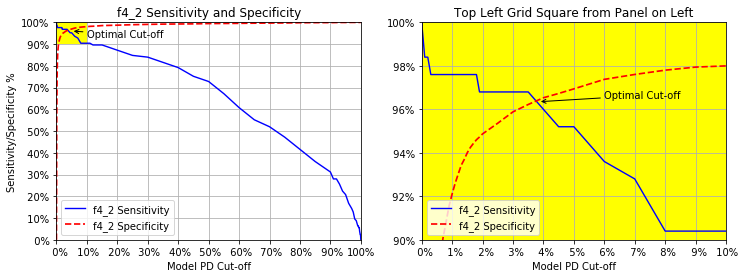

In [70]:
from matplotlib.patches import Rectangle

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3,fontsize=10)
plt.annotate('Optimal Cut-off', xy=(.05,.96), xytext=(.1, .93),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3, fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.0385,.9635), xytext=(.06, .965),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')
plt.savefig('SensSpecOptCut_f4_2_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()

C:\Users\Denni\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\Denni\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


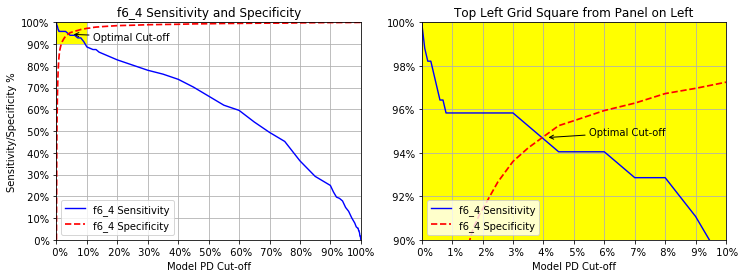

In [71]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3,fontsize=10)
plt.annotate('Optimal Cut-off', xy=(.05,.945), xytext=(.12, .92),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3,fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.041,.947), xytext=(.055, .948),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')
plt.savefig('SensSpecOptCut_f6_4_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()

C:\Users\Denni\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\Denni\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


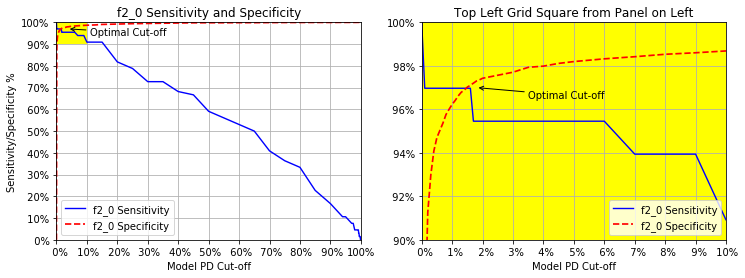

In [72]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3, fontsize=10)
plt.annotate('Optimal Cut-off', xy=(.037,.97), xytext=(.11, .94),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4,fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.018,.97), xytext=(.035, .965),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')

plt.savefig('SensSpecOptCut_f2_0_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()


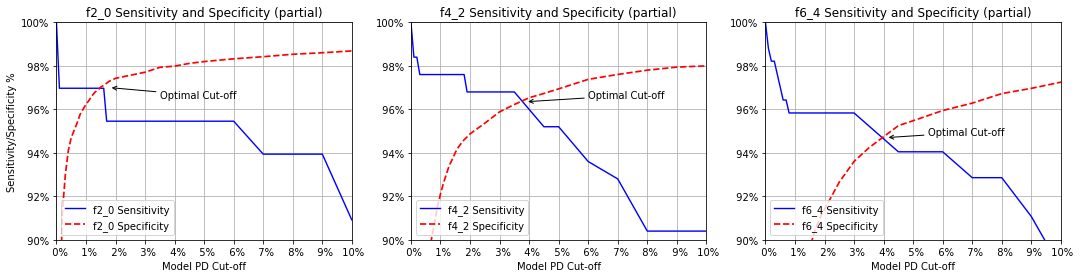

In [74]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 3, 1)
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.ylabel('Sensitivity/Specificity %')
plt.legend(loc=3,fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.018,.97), xytext=(.035, .965),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity (partial)')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3, fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.039,.9635), xytext=(.06, .965),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity (partial)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3,fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.041,.947), xytext=(.055, .948),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity (partial)')
plt.grid(True)

plt.savefig('SensSpecOptCut_f246partial_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()

In [75]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
488415 2009-12-31   0   0   0   0  8.829546e-10  1.267444e-09  2.786002e-08   
488453 2009-12-31   0   0   0   0  6.896306e-07  8.833574e-07  7.040838e-06   

                f4_3          f6_4    ...      f6_qnTotLn  f2_eBrok_Dep  \
488415  2.136526e-08  7.937966e-07    ...        0.002779      0.001012   
488453  2.234755e-06  2.030625e-05    ...        0.002779      0.001012   

        f4_eBrok_Dep  f6_eBrok_Dep  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
488415      0.002538      0.004118    0.001299    0.003233    0.005200   
488453      0.002538      0.004118    0.001335    0.003340    0.005395   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
488415   0.001673   0.003951   0.005825  
488453   0.001565   0.003802   0.005821  

[2 rows x 41 columns]

In [76]:
## dffg: check 96% percentile levels:
dffg.columns

Index([u'AsOf', u'f2', u'f4', u'f6', u'f8', u'f2_0', u'f2_1', u'f4_2', u'f4_3',
       u'f6_4', u'f6_5', u'f2_0rr', u'f2_1rr', u'f4_2rr', u'f4_3rr', u'f6_4rr',
       u'f6_5rr', u'f2_lnTotAst', u'f4_lnTotAst', u'f6_lnTotAst', u'f2_rROE',
       u'f4_rROE', u'f6_rROE', u'f2_rROA', u'f4_rROA', u'f6_rROA', u'f2_eT1rb',
       u'f4_eT1rb', u'f6_eT1rb', u'f2_qnTotLn', u'f4_qnTotLn', u'f6_qnTotLn',
       u'f2_eBrok_Dep', u'f4_eBrok_Dep', u'f6_eBrok_Dep', u'f2_eLn_Dep',
       u'f4_eLn_Dep', u'f6_eLn_Dep', u'f2_aFF_TA', u'f4_aFF_TA', u'f6_aFF_TA'],
      dtype='object')

In [77]:
dffg[['f2_0','f4_2','f6_4']].quantile(.96) # distorted by mixing TN, FPs

f2_0    0.013689
f4_2    0.065894
f6_4    0.140935
dtype: float64

In [78]:
dffg[['f2_1','f4_3','f6_5']].quantile(.96) # distorted by mixing TN, FPs

f2_1    0.013962
f4_3    0.069107
f6_5    0.136232
dtype: float64

In [79]:
dffg[dffg['f4']==0][['f4_2','f4_3']].quantile(.96).values, dffg[dffg['f4']==1][['f4_2','f4_3']].quantile(.04).values

(array([ 0.03200052,  0.03422167]), array([ 0.04032042,  0.04360466]))

In [80]:
dffg[dffg['f2']==0][['f2_0','f2_1']].quantile(.96).values, dffg[dffg['f2']==1][['f2_0','f2_1']].quantile(.04).values

(array([ 0.0089711 ,  0.00907645]), array([ 0.04324287,  0.04490872]))

In [81]:
dffg[dffg['f6']==0][['f6_4','f6_5']].quantile(.96).values, dffg[dffg['f6']==1][['f6_4','f6_5']].quantile(.04).values

(array([ 0.06116101,  0.05603663]), array([ 0.02478487,  0.02105114]))

In [82]:
## conclusion:  always use 96%ile of no-fails (large group) if possible... worst4% is a very rough approx that is OK to model!